In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import os
import re
import gc
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!/bin/bash
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
# if [[ ! -f 'spark-3.2.2-bin-hadoop3.2.tgz' ]];
# then
#     wget https://archive.apache.org/dist/spark/spark-3.2.2/spark-3.2.2-bin-hadoop3.2.tgz
# else
#     echo "file spark-3.2.2-bin-hadoop3.2.tgz already exists!"
# fi

# chmod -R 777 /content/drive/MyDrive/spark-3.2.2-bin-hadoop3.2
# !wget https://archive.apache.org/dist/spark/spark-3.2.2/spark-3.2.2-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf /content/drive/MyDrive/spark-3.2.2-bin-hadoop3.2.tgz

!pip install -q findspark
!pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 21.8 MB/s eta 0:00:00


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.2-bin-hadoop3.2"

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window as W
from pyspark.sql.types import BooleanType
spark = (SparkSession.builder\
        #  .master('local')\
        #  .appName('Colab')\
        #  .config('spark.ui.port', '4050')\
         .getOrCreate()
         )
spark

In [ ]:
# tg = spark.read.parquet('/content/drive/MyDrive/Диссертация/Парсеры сайтов/tg.parquet')

In [ ]:
# news = pd.read_parquet('/content/drive/MyDrive/Диссертация/Парсеры сайтов/news.parquet')

In [ ]:
# def to_bool(df):
#   for col in df.columns:
#     if df[col].contains('True'):
#       df.withColumn(col, df.age.cast(BooleanType()))
#   return df

In [ ]:
# news = to_bool(news)
# tg = to_bool(tg)

In [3]:
sectors = ['finance', 'gold', 'ferrous_metallurgy', 'oil_gas', 'non_ferrous_metallurgy', 'electrical networks', 'telecom', 'it', 'real_estate']
companies = ['ALRS', 'AFLT', 'VTBR', 'GAZP', 'GMKN', 'LSRG', 'DSKY', 'IRAO', 'LKOH', 'MAGN', 'MOEX', 'CBOM', 'MTSS', 'ROSN', 'NLMK', 'NVTK', 'PIKK', 'PLZL',
              'RTKM', 'RUAL', 'HYDR', 'SBER', 'CHMF', 'AFKS', 'SNGS', 'TATN', 'TCSG', 'TRNFP', 'POGR', 'PHOR', 'FEES', 'HHRU', 'YNDX']

In [ ]:
# print((tg.count(), len(tg.columns)))

In [ ]:
# def get_time_lags(df, mins, hours, days, com):
#     price = pd.read_csv(f'/content/drive/MyDrive/Диссертация/Парсеры сайтов/Стоимость акций/1 мин/{com}.csv')
#     price['timestamp'] = pd.to_datetime(price['timestamp'])
#     price.rename(columns={'timestamp':'date'}, inplace=True)
#     price.sort_values('date', ignore_index=True, inplace=True)
    
#     tmp_mins = pd.DataFrame()
#     for m in mins:
#         delta = pd.Timedelta(m, unit='min')
#         df['date'] -= delta
#         mins_price = pd.merge_asof(df, price, on='date', direction='backward')['close']
#         df['date'] += delta
#         tmp_mins = pd.concat([tmp_mins, mins_price], axis=1)
        
#     tmp_mins = tmp_mins.to_numpy()
    
#     tmp_hours = pd.DataFrame()
#     for h in hours:
#         m = 60 * h
#         delta = pd.Timedelta(m, unit='min')
#         df['date'] -= delta
#         hours_price = pd.merge_asof(df, price, on='date', direction='backward')['close']
#         df['date'] += delta
#         tmp_hours = pd.concat([tmp_hours, hours_price], axis=1)
        
#     tmp_hours = tmp_hours.to_numpy()
    
#     tmp_days = pd.DataFrame()
#     for d in days:
#         m = 24 * 60 * d
#         delta = pd.Timedelta(m, unit='min')
#         df['date'] -= delta
#         days_price = pd.merge_asof(df, price, on='date', direction='backward')['close']
#         df['date'] += delta
#         tmp_days = pd.concat([tmp_days, days_price], axis=1)
    
#     tmp_days.dropna(inplace=True)
    
#     return tmp_mins, tmp_hours, tmp_days

## Телеграмм

In [ ]:
tg = pd.read_parquet('/content/drive/MyDrive/Диссертация/Парсеры сайтов/tg.parquet')
tg_raw = pd.read_parquet('/content/drive/MyDrive/Диссертация/Парсеры сайтов/tg_raw.parquet')
tg.drop(columns=[x for x in tg.columns if bool(re.search('_close', x))], inplace=True)
tg = tg.iloc[:, :2].copy()
tg = tg.merge(tg_raw, how='left', on='date')
del tg_raw
tg.dropna(subset=['message_x', 'message_y', 'date'], inplace=True)

In [ ]:
tg = tg.drop(columns=['views', 'forwards', 'fwd_from'])
tg = tg[tg.date < '2022-01-01'].copy()
tg = tg.drop(columns=sectors)
tg.rename(columns={'message_x': 'message_prep', 'message_y': 'message_raw'}, inplace=True)

In [ ]:
# Случайный лес
targets = tg.iloc[3:,:-1].columns
for company in companies:
  print(company)
  # os.mkdir(f'/content/drive/MyDrive/Диссертация/{company}')
  comp = tg[tg[company] == True].copy()
  comp.dropna(inplace=True)
  train, test = comp.iloc[:int(0.8*len(comp)), :], comp.iloc[int(0.8*len(comp)):, :]
  tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1,2))
  features_train = tfidf.fit_transform(train['message_prep'])
  features_test = tfidf.transform(test['message_prep'])
  X_train = features_train.todense()
  X_test = features_test.todense()
  tr = [col for col in targets if company in col]
  train_logg = []
  test_logg = []
  base_acc = []
  for t in tr:
    y_train = train[t].values.astype(int)
    y_test = test[t].values.astype(int)
    base_acc.append(np.mean(y_train))
    for depth in range(3, 16):
      clf = RandomForestClassifier(random_state=123, criterion='entropy', n_jobs=-1, max_depth=depth)
      y_pred = clf.fit(np.asarray(X_train), y_train).predict(np.asarray(X_test))
      test_logg.append(np.mean(y_test==y_pred))
      train_pred = clf.predict(np.asarray(X_train))
      train_logg.append(np.mean(y_train==train_pred))

  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{company}/{company}_train_logg2.txt', 'w') as fp:
    for item in train_logg:
        fp.write("%s\n" % item)
  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{company}/{company}_test_logg2.txt', 'w') as fp:
    for item in test_logg:
        fp.write("%s\n" % item)

  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{company}/{company}_base_acc_logg2.txt', 'w') as fp:
    for item in base_acc:
        fp.write("%s\n" % item)

  
  print(f'{company} done')

ALRS
ALRS done
AFLT
AFLT done
VTBR
VTBR done
GAZP
GAZP done
GMKN
GMKN done
LSRG
LSRG done
DSKY
DSKY done
IRAO
IRAO done
LKOH
LKOH done
MAGN
MAGN done
MOEX
MOEX done
CBOM
CBOM done
MTSS
MTSS done
ROSN
ROSN done
NLMK
NLMK done
NVTK
NVTK done
PIKK
PIKK done
PLZL
PLZL done
RTKM
RTKM done
RUAL
RUAL done
HYDR
HYDR done
SBER
SBER done
CHMF
CHMF done
AFKS
AFKS done
SNGS
SNGS done
TATN
TATN done
TCSG
TCSG done
TRNFP
TRNFP done
POGR
POGR done
PHOR
PHOR done
FEES
FEES done
HHRU
HHRU done
YNDX
YNDX done


In [ ]:
#Градиентный бустинг
targets = tg.iloc[3:,:-1].columns
for company in companies:
  print(company)
  # os.mkdir(f'/content/drive/MyDrive/Диссертация/{company}')
  comp = tg[tg[company] == True].copy()
  comp.dropna(inplace=True)
  train, test = comp.iloc[:int(0.8*len(comp)), :], comp.iloc[int(0.8*len(comp)):, :]
  tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1,2))
  features_train = tfidf.fit_transform(train['message_prep'])
  features_test = tfidf.transform(test['message_prep'])
  X_train = features_train.todense()
  X_test = features_test.todense()
  tr = [col for col in targets if company in col]
  train_logg = []
  test_logg = []
  base_acc = []
  for t in tr:
    y_train = train[t].values.astype(int)
    y_test = test[t].values.astype(int)
    base_acc.append(np.mean(y_train))
    for depth in range(3, 16):
      clf = LGBMClassifier(random_state=123, n_jobs=-1, max_depth=depth)
      y_pred = clf.fit(np.asarray(X_train), y_train).predict(np.asarray(X_test))
      test_logg.append(np.mean(y_test==y_pred))
      train_pred = clf.predict(np.asarray(X_train))
      train_logg.append(np.mean(y_train==train_pred))

  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{company}/{company}_train_logg_boosting2.txt', 'w') as fp:
    for item in train_logg:
        fp.write("%s\n" % item)
  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{company}/{company}_test_logg_boosting2.txt', 'w') as fp:
    for item in test_logg:
        fp.write("%s\n" % item)

  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{company}/{company}_base_acc_logg_boosting2.txt', 'w') as fp:
    for item in base_acc:
        fp.write("%s\n" % item)

  
  print(f'{company} done')

ALRS
ALRS done
AFLT
AFLT done
VTBR
VTBR done
GAZP
GAZP done
GMKN
GMKN done
LSRG
LSRG done
DSKY
DSKY done
IRAO
IRAO done
LKOH
LKOH done
MAGN
MAGN done
MOEX
MOEX done
CBOM
CBOM done
MTSS
MTSS done
ROSN
ROSN done
NLMK
NLMK done
NVTK
NVTK done
PIKK
PIKK done
PLZL
PLZL done
RTKM
RTKM done
RUAL
RUAL done
HYDR
HYDR done
SBER
SBER done
CHMF
CHMF done
AFKS
AFKS done
SNGS
SNGS done
TATN
TATN done
TCSG
TCSG done
TRNFP
TRNFP done
POGR
POGR done
PHOR
PHOR done
FEES
FEES done
HHRU
HHRU done
YNDX
YNDX done


### Сведение результатов в таблицу

In [ ]:
results_rf = pd.DataFrame(columns=['1 min test', '1 min train', 'base 1 min', '5 min test', '5 min train', 'base 5 min', '10 min test', '10 min train', 'base 10 min', '15 min test', '15 min train', 'base 15 min',
                                   '30 min test', '30 min train', 'base 30 min', '1 hour test', '1 hour train', 'base 1 hour', '1 day test', '1 day train', 'base 1 day'], index=companies)

In [ ]:
for comp in companies:
  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{comp}/{comp}_train_logg2.txt') as f:
      lines = f.readlines()
      lines_train = [float(el[:-2]) for el in lines]
      lines_train = np.array(lines_train).reshape(-1, 13)
      lines_train = lines_train[:-1]

  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{comp}/{comp}_test_logg2.txt') as f:
      lines = f.readlines()
      lines_test = [float(el[:-2]) for el in lines]
      lines_test = np.array(lines_test).reshape(-1, 13)
      lines_test = lines_test[:-1]
      inds_max = np.argmax(lines_test, axis=1)

  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{comp}/{comp}_base_acc_logg2.txt') as f:
      lines = f.readlines()
      base_train = [float(el[:-2]) for el in lines]
      base_train = base_train[:-1]

  lines_train = np.choose(inds_max, lines_train.T)
  lines_test = np.choose(inds_max, lines_test.T)

  res = []
  for tr, te, ba in zip(lines_train, lines_test, base_train):
    res.append(te)
    res.append(tr)
    res.append(ba)


  results_rf.loc[comp,:] = res

In [ ]:
pd.set_option('display.max_columns', 21)
pd.set_option('display.max_rows', 33)

In [ ]:
results_rf

,1 min test,1 min train,base 1 min,5 min test,5 min train,base 5 min,10 min test,10 min train,base 10 min,15 min test,15 min train,base 15 min,30 min test,30 min train,base 30 min,1 hour test,1 hour train,base 1 hour,1 day test,1 day train,base 1 day
ALRS,0.531046,0.662852,0.555783,0.542484,0.818962,0.517777,0.529412,0.792399,0.522272,0.503268,0.624847,0.51982,0.555556,0.654271,0.515325,0.547386,0.721291,0.52595,0.740196,0.689416,0.63302
AFLT,0.570079,0.817967,0.509456,0.588976,0.823483,0.513396,0.566929,0.858944,0.50985,0.576378,0.795114,0.50985,0.615748,0.839638,0.504334,0.55748,0.774626,0.483846,0.579528,0.683215,0.454689
VTBR,0.534768,0.54616,0.54616,0.537666,0.567791,0.5355,0.534354,0.547713,0.532498,0.516556,0.550818,0.525254,0.523593,0.559822,0.534879,0.536838,0.610226,0.521528,0.565397,0.71155,0.506106
GAZP,0.537556,0.539355,0.535058,0.543285,0.55201,0.542778,0.54233,0.558058,0.534023,0.536283,0.561242,0.529725,0.532782,0.564743,0.525348,0.543285,0.562595,0.528054,0.557288,0.582252,0.531078
GMKN,0.568567,0.836868,0.488238,0.553159,0.853837,0.51022,0.53775,0.887775,0.503278,0.57319,0.753182,0.494022,0.57319,0.786734,0.492094,0.605547,0.801774,0.494794,0.639445,0.701118,0.701118
LSRG,0.545977,0.854257,0.546898,0.511494,0.681097,0.577201,0.528736,0.760462,0.561328,0.488506,0.666667,0.545455,0.557471,0.874459,0.536797,0.54023,0.825397,0.568543,0.597701,0.875902,0.489177
DSKY,0.581818,0.799091,0.591818,0.618182,0.767273,0.623636,0.607273,0.753636,0.601818,0.592727,0.612727,0.573636,0.607273,0.692727,0.584545,0.570909,0.763636,0.581818,0.538182,0.769091,0.550909
IRAO,0.590331,0.68746,0.550605,0.541985,0.665181,0.537874,0.554707,0.761935,0.526416,0.56743,0.891789,0.507957,0.605598,0.858052,0.510503,0.605598,0.833227,0.520687,0.569975,0.858052,0.478676
LKOH,0.529193,0.720323,0.515538,0.551553,0.753884,0.518024,0.535404,0.833126,0.507458,0.52795,0.745805,0.523306,0.535404,0.773151,0.523928,0.556522,0.697949,0.538844,0.572671,0.708204,0.545681
MAGN,0.526316,0.757437,0.544622,0.562929,0.739703,0.526888,0.558352,0.752288,0.536041,0.558352,0.804348,0.52746,0.549199,0.758009,0.525744,0.562929,0.877002,0.493135,0.558352,0.738558,0.451945


In [ ]:
results_boosting = pd.DataFrame(columns=['1 min test', '1 min train', 'base 1 min', '5 min test', '5 min train', 'base 5 min', '10 min test', '10 min train', 'base 10 min', '15 min test', '15 min train', 'base 15 min',
                                         '30 min test', '30 min train', 'base 30 min', '1 hour test', '1 hour train', 'base 1 hour', '1 day test', '1 day train', 'base 1 day'], index=companies)

In [ ]:
for comp in companies:
  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{comp}/{comp}_train_logg_boosting2.txt') as f:
      lines = f.readlines()
      lines_train = [float(el[:-2]) for el in lines]
      lines_train = np.array(lines_train).reshape(-1, 13)
      lines_train = lines_train[:-1]

  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{comp}/{comp}_test_logg_boosting2.txt') as f:
      lines = f.readlines()
      lines_test = [float(el[:-2]) for el in lines]
      lines_test = np.array(lines_test).reshape(-1, 13)
      lines_test = lines_test[:-1]
      inds_max = np.argmax(lines_test, axis=1)

  with open(f'/content/drive/MyDrive/Диссертация/tg_loggs/{comp}/{comp}_base_acc_logg_boosting2.txt') as f:
      lines = f.readlines()
      base_train = [float(el[:-2]) for el in lines]
      base_train = base_train[:-1]

  lines_train = np.choose(inds_max, lines_train.T)
  lines_test = np.choose(inds_max, lines_test.T)

  res = []
  for tr, te, ba in zip(lines_train, lines_test, base_train):
    res.append(te)
    res.append(tr)
    res.append(ba)


  results_boosting.loc[comp,:] = res

In [ ]:
results_boosting

,1 min test,1 min train,base 1 min,5 min test,5 min train,base 5 min,10 min test,10 min train,base 10 min,15 min test,15 min train,base 15 min,30 min test,30 min train,base 30 min,1 hour test,1 hour train,base 1 hour,1 day test,1 day train,base 1 day
ALRS,0.583333,0.87454,0.555783,0.583333,0.815284,0.517777,0.552288,0.900286,0.522272,0.542484,0.830405,0.51982,0.562092,0.900695,0.515325,0.54902,0.895791,0.52595,0.743464,0.936248,0.63302
AFLT,0.584252,0.873522,0.509456,0.611024,0.919228,0.513396,0.574803,0.905437,0.50985,0.590551,0.862884,0.50985,0.59685,0.916076,0.504334,0.607874,0.915682,0.483846,0.620472,0.91647,0.454689
VTBR,0.550083,0.761437,0.54616,0.555877,0.793625,0.5355,0.551738,0.801697,0.532498,0.573262,0.799317,0.525254,0.544288,0.797247,0.534879,0.548013,0.671911,0.521528,0.579884,0.763507,0.506106
GAZP,0.55156,0.779387,0.535058,0.551241,0.779069,0.542778,0.565882,0.783446,0.534023,0.561108,0.803343,0.529725,0.568109,0.81735,0.525348,0.570656,0.806367,0.528054,0.593889,0.817509,0.531078
GMKN,0.539291,0.920555,0.488238,0.539291,0.789047,0.51022,0.533128,0.884304,0.503278,0.548536,0.915156,0.494022,0.571649,0.916699,0.492094,0.583975,0.918627,0.494794,0.671803,0.956421,0.701118
LSRG,0.505747,0.92785,0.546898,0.574713,0.92785,0.577201,0.603448,0.936508,0.561328,0.534483,0.875902,0.545455,0.586207,0.930736,0.536797,0.568966,0.94228,0.568543,0.643678,0.914863,0.489177
DSKY,0.607273,0.815455,0.591818,0.603636,0.801818,0.623636,0.636364,0.898182,0.601818,0.570909,0.914545,0.573636,0.629091,0.946364,0.584545,0.592727,0.876364,0.581818,0.574545,0.916364,0.550909
IRAO,0.618321,0.894971,0.550605,0.613232,0.91916,0.537874,0.564885,0.915341,0.526416,0.633588,0.891789,0.507957,0.638677,0.930617,0.510503,0.636132,0.756843,0.520687,0.585242,0.953533,0.478676
LKOH,0.536646,0.8844,0.515538,0.56646,0.869173,0.518024,0.545342,0.866998,0.507458,0.575155,0.83064,0.523306,0.567702,0.911125,0.523928,0.624845,0.906153,0.538844,0.607453,0.878185,0.545681
MAGN,0.581236,0.909039,0.544622,0.590389,0.910755,0.526888,0.590389,0.762014,0.536041,0.574371,0.918764,0.52746,0.558352,0.927346,0.525744,0.526316,0.929062,0.493135,0.546911,0.863844,0.451945


### Нейросетевой подход

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import BertTokenizer
from transformers import BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')

In [ ]:
class TgDataset(Dataset):
    def __init__(self, texts, targets):
    
      self.labels = targets.astype(int)
      self.texts = [tokenizer(text, 
                          padding='max_length', max_length = 512, truncation=True,
                          return_tensors="pt") for text in texts]

    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_y = self.labels[idx]

        return batch_texts, batch_y

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, n_classes=7):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
        self.classifier = nn.Linear(768, n_classes)
        self.act = nn.Softmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        final = self.classifier(pooled_output)
        final = self.act(final)
        return final

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

def train(model, train_texts, val_texts, train_target, val_target, learning_rate, epochs):

    train, val = TgDataset(train_texts, train_target), TgDataset(val_texts, val_target)

    mean_1_min, mean_5_min, mean_10_min, mean_15_min, mean_30_min, mean_1_hour, mean_1_day = train_target.mean(axis=0)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCELoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            acc_1_min_train = 0
            acc_5_min_train = 0
            acc_10_min_train = 0
            acc_15_min_train = 0
            acc_30_min_train = 0
            acc_1_hour_train = 0
            acc_1_day_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.float())
                total_loss_train += batch_loss.item()
                
                acc_1_min_train += ((output[:,0] > mean_1_min).int() == train_label[:,0]).sum().item()
                acc_5_min_train += ((output[:,1] > mean_5_min).int() == train_label[:,1]).sum().item()
                acc_10_min_train += ((output[:,2] > mean_10_min).int() == train_label[:,2]).sum().item()
                acc_15_min_train += ((output[:,3] > mean_15_min).int() == train_label[:,3]).sum().item()
                acc_30_min_train += ((output[:,4] > mean_30_min).int() == train_label[:,4]).sum().item()
                acc_1_hour_train += ((output[:,5] > mean_1_hour).int() == train_label[:,5]).sum().item()
                acc_1_day_train += ((output[:,6] > mean_1_day).int() == train_label[:,6]).sum().item()

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            acc_1_min_val = 0
            acc_5_min_val = 0
            acc_10_min_val = 0
            acc_15_min_val = 0
            acc_30_min_val = 0
            acc_1_hour_val = 0
            acc_1_day_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.float())
                    total_loss_val += batch_loss.item()
                    
                    acc_1_min_val += ((output[:,0] > mean_1_min).int() == val_label[:,0]).sum().item()
                    acc_5_min_val += ((output[:,1] > mean_5_min).int() == val_label[:,1]).sum().item()
                    acc_10_min_val += ((output[:,2] > mean_10_min).int() == val_label[:,2]).sum().item()
                    acc_15_min_val += ((output[:,3] > mean_15_min).int() == val_label[:,3]).sum().item()
                    acc_30_min_val += ((output[:,4] > mean_30_min).int() == val_label[:,4]).sum().item()
                    acc_1_hour_val += ((output[:,5] > mean_1_hour).int() == val_label[:,5]).sum().item()
                    acc_1_day_val += ((output[:,6] > mean_1_day).int() == val_label[:,6]).sum().item()
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train): .3f} \
                | Train Acc 1 min: {acc_1_min_train / len(train): .3f} \
                | Train Acc 5 min: {acc_5_min_train / len(train): .3f} \
                | Train Acc 10 min: {acc_10_min_train / len(train): .3f} \
                | Train Acc 15 min: {acc_15_min_train / len(train): .3f} \
                | Train Acc 30 min: {acc_30_min_train / len(train): .3f} \
                | Train Acc 1 hour: {acc_1_hour_train / len(train): .3f} \
                | Train Acc 1 day: {acc_1_day_train / len(train): .3f} \
                | Val Loss: {total_loss_val / len(val): .3f} \
                | Val Acc 1 min: {acc_1_min_val / len(val): .3f} \
                | Val Acc 5 min: {acc_5_min_val / len(val): .3f} \
                | Val Acc 10 min: {acc_10_min_val / len(val): .3f} \
                | Val Acc 15 min: {acc_15_min_val / len(val): .3f} \
                | Val Acc 30 min: {acc_30_min_val / len(val): .3f} \
                | Val Acc 1 hour: {acc_1_hour_val / len(val): .3f} \
                | Val Acc 1 day: {acc_1_day_val / len(val): .3f}')

In [ ]:
EPOCHS = 3
model = BertClassifier()
LR = 1e-6

Some weights of the model checkpoint at SkolkovoInstitute/russian_toxicity_classifier were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
count = tg['message_raw'].str.split().apply(len)

In [ ]:
(count == 0).sum()

17933

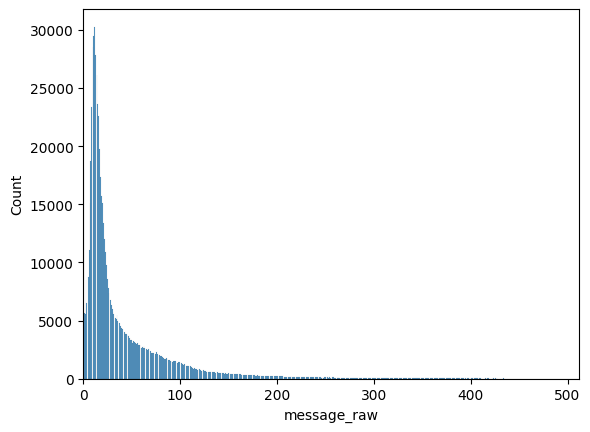

In [ ]:
sns.histplot(count)
plt.xlim([0, 512]);

In [ ]:
comp = tg[tg['GAZP'] == True].copy()
comp.dropna(inplace=True)
train_data, test_data = comp.iloc[:int(0.8*len(comp)), :], comp.iloc[int(0.8*len(comp)):, :]
cols = [col for col in train_data.columns if 'GAZP_' in col]

In [ ]:
counts_gazp = train_data['message_raw'].str.split().apply(len)

In [ ]:
counts_gazp.max()

515

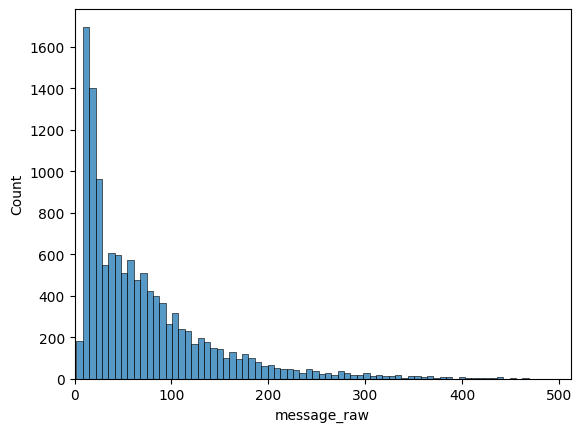

In [ ]:
sns.histplot(counts_gazp)
plt.xlim([0, 512]);

In [ ]:
train_texts, val_texts = train_data['message_raw'].values, test_data['message_raw'].values
train_target, val_target = train_data[cols].values, test_data[cols].values

In [ ]:
train(model, train_texts, val_texts, train_target, val_target, LR, EPOCHS)

100%|██████████| 1571/1571 [19:15<00:00,  1.36it/s]


Epochs: 1 | Train Loss:  0.139                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.140                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


100%|██████████| 1571/1571 [19:20<00:00,  1.35it/s]


Epochs: 2 | Train Loss:  0.138                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.140                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


100%|██████████| 1571/1571 [19:21<00:00,  1.35it/s]


Epochs: 3 | Train Loss:  0.138                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.140                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Диссертация/Tg_raw_Bert_russian_toxicity_classifier.pth')

In [ ]:
def evaluate(model, test_texts, test_target, train_target):

    mean_1_min, mean_5_min, mean_10_min, mean_15_min, mean_30_min, mean_1_hour, mean_1_day = train_target.mean(axis=0)
    test = TgDataset(test_texts, test_target)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    acc_1_min_test = 0
    acc_5_min_test = 0
    acc_10_min_test = 0
    acc_15_min_test = 0
    acc_30_min_test = 0
    acc_1_hour_test = 0
    acc_1_day_test = 0
    total_loss_test = 0

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc_1_min_test += ((output[:,0] > mean_1_min).int() == test_label[:,0]).sum().item()
              acc_5_min_test += ((output[:,1] > mean_5_min).int() == test_label[:,1]).sum().item()
              acc_10_min_test += ((output[:,2] > mean_10_min).int() == test_label[:,2]).sum().item()
              acc_15_min_test += ((output[:,3] > mean_15_min).int() == test_label[:,3]).sum().item()
              acc_30_min_test += ((output[:,4] > mean_30_min).int() == test_label[:,4]).sum().item()
              acc_1_hour_test += ((output[:,5] > mean_1_hour).int() == test_label[:,5]).sum().item()
              acc_1_day_test += ((output[:,6] > mean_1_day).int() == test_label[:,6]).sum().item()
            
    print(
      f'| Test Acc 1 min: {acc_1_min_test / len(test): .3f} \
      | Test Acc 5 min: {acc_5_min_test / len(test): .3f} \
      | Test Acc 10 min: {acc_10_min_test / len(test): .3f} \
      | Test Acc 15 min: {acc_15_min_test / len(test): .3f} \
      | Test Acc 30 min: {acc_30_min_test / len(test): .3f} \
      | Test Acc 1 hour: {acc_1_hour_test / len(test): .3f} \
      | Test Acc 1 day: {acc_1_day_test / len(test): .3f}')
    
evaluate(model, val_texts, val_target, train_target)

In [ ]:
train_texts, val_texts = train_data['message_prep'].values, test_data['message_prep'].values
train_target, val_target = train_data[cols].values, test_data[cols].values

In [ ]:
EPOCHS = 3
model = BertClassifier()
LR = 3e-4

Some weights of the model checkpoint at SkolkovoInstitute/russian_toxicity_classifier were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train(model, train_texts, val_texts, train_target, val_target, LR, EPOCHS)

100%|██████████| 1571/1571 [19:04<00:00,  1.37it/s]


Epochs: 1 | Train Loss:  0.139                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.142                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


100%|██████████| 1571/1571 [19:08<00:00,  1.37it/s]


Epochs: 2 | Train Loss:  0.139                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.142                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


100%|██████████| 1571/1571 [19:08<00:00,  1.37it/s]


Epochs: 3 | Train Loss:  0.139                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.141                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Диссертация/Tg_prep_Bert_russian_toxicity_classifier.pth')

In [ ]:
evaluate(model, val_texts, val_target, train_target)

| Test Acc 1 min:  0.463       | Test Acc 5 min:  0.458       | Test Acc 10 min:  0.460       | Test Acc 15 min:  0.468       | Test Acc 30 min:  0.472       | Test Acc 1 hour:  0.462       | Test Acc 1 day:  0.457


## Традиционные новости

In [ ]:
# news_raw = pd.read_parquet('/kaggle/input/dissertation-raw/news_raw.parquet')
# news_raw.drop(columns=['link', 'source'], inplace=True)
# news_raw['title'] = news_raw['title'].str.lower().str.replace('no title', '')
# news_raw['announce'] = news_raw['announce'].str.lower().str.replace('no announce', '')
# news_raw['text'] = news_raw['text'].str.lower().str.replace('no text', '')

# news_raw['full_text'] = news_raw['title'] + ' ' + news_raw['announce'] +  ' ' + news_raw['text']
# news_raw.drop(columns=['title', 'announce', 'text'], inplace=True)
# news_raw.drop_duplicates(subset=['date'], inplace=True, ignore_index=True)

# gc.collect()

# news = pd.read_parquet('/kaggle/input/dissertation/news.parquet')
# news.drop(columns=[x for x in news.columns if bool(re.search('close', x))] + ['link', 'source'], inplace=True)
# news.drop_duplicates(subset=['date'], inplace=True, ignore_index=True)

# news['title'] = news['title'].str.lower().str.replace('no title', '')
# news['announce'] = news['announce'].str.lower().str.replace('no announce', '')
# news['text'] = news['text'].str.lower().str.replace('no text', '')

# news['full_text'] = news['title'] + ' ' + news['announce'] +  ' ' + news['text']
# news.drop(columns=['title', 'announce', 'text'], inplace=True)
# news = news.loc[:, ['date', 'full_text']].copy()

# gc.collect()
# news = news.merge(news_raw, how='left', on='date')
# del news_raw
# news.dropna(subset=['full_text_x', 'full_text_y', 'date'], inplace=True)
# news.rename(columns={'full_text_x': 'message_prep', 'full_text_y': 'message_raw'}, inplace=True)

In [4]:
news = pd.read_parquet('/content/drive/MyDrive/news_agg.parquet')

In [5]:
news.drop('message_raw', axis=1, inplace=True)

In [ ]:
# news = spark.read.parquet('/content/drive/MyDrive/Диссертация/Парсеры сайтов/news_agg.parquet')

In [6]:
news = news[news.date < '2022-01-01']
# news = news.drop(columns=sectors)

In [8]:
# Случайный лес
targets = news.iloc[:, 2:].columns
for company in companies:
    print(company)
    os.mkdir(f'/content/drive/MyDrive/news_loggs/{company}')
    comp = news[news[company] == True].copy()
    comp.dropna(inplace=True)
    train, test = comp.iloc[:int(0.8*len(comp)), :], comp.iloc[int(0.8*len(comp)):, :]
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1,2))
    features_train = tfidf.fit_transform(train['message_prep'])
    features_test = tfidf.transform(test['message_prep'])
    X_train = features_train.todense()
    X_test = features_test.todense()
    tr = [col for col in targets if company in col]
    tr.remove(company)
    train_logg = []
    test_logg = []
    base_acc = []
    for t in tr:
        y_train = train[t].values.astype(int)
        y_test = test[t].values.astype(int)
        base_acc.append(np.mean(y_train))
    for depth in range(3, 16):
        clf = RandomForestClassifier(random_state=123, criterion='entropy', n_jobs=-1, max_depth=depth)
        y_pred = clf.fit(np.asarray(X_train), y_train).predict(np.asarray(X_test))
        test_logg.append(np.mean(y_test==y_pred))
        train_pred = clf.predict(np.asarray(X_train))
        train_logg.append(np.mean(y_train==train_pred))

    with open(f'/content/drive/MyDrive/news_loggs/{company}/{company}_train_logg.txt', 'w') as fp:
      for item in train_logg:
        fp.write("%s\n" % item)
    with open(f'/content/drive/MyDrive/news_loggs/{company}/{company}_test_logg.txt', 'w') as fp:
      for item in test_logg:
        fp.write("%s\n" % item)

    with open(f'/content/drive/MyDrive/news_loggs/{company}/{company}_base_acc_logg.txt', 'w') as fp:
      for item in base_acc:
        fp.write("%s\n" % item)


    print(f'{company} done')

ALRS
ALRS done
AFLT
AFLT done
VTBR
VTBR done
GAZP
GAZP done
GMKN
GMKN done
LSRG
LSRG done
DSKY
DSKY done
IRAO
IRAO done
LKOH
LKOH done
MAGN
MAGN done
MOEX
MOEX done
CBOM
CBOM done
MTSS
MTSS done
ROSN
ROSN done
NLMK
NLMK done
NVTK
NVTK done
PIKK
PIKK done
PLZL
PLZL done
RTKM
RTKM done
RUAL
RUAL done
HYDR
HYDR done
SBER
SBER done
CHMF
CHMF done
AFKS
AFKS done
SNGS
SNGS done
TATN
TATN done
TCSG
TCSG done
TRNFP
TRNFP done
POGR
POGR done
PHOR
PHOR done
FEES
FEES done
HHRU
HHRU done
YNDX
YNDX done


In [9]:
#Градиентный бустинг
targets = news.iloc[:, 2:].columns
for company in companies:
  print(company)
  # os.mkdir(f'/content/drive/MyDrive/Диссертация/{company}')
  comp = news[news[company] == True].copy()
  comp.dropna(inplace=True)
  train, test = comp.iloc[:int(0.8*len(comp)), :], comp.iloc[int(0.8*len(comp)):, :]
  tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1,2))
  features_train = tfidf.fit_transform(train['message_prep'])
  features_test = tfidf.transform(test['message_prep'])
  X_train = features_train.todense()
  X_test = features_test.todense()
  tr = [col for col in targets if company in col]
  tr.remove(company)
  train_logg = []
  test_logg = []
  base_acc = []
  for t in tr:
    y_train = train[t].values.astype(int)
    y_test = test[t].values.astype(int)
    base_acc.append(np.mean(y_train))
    for depth in range(3, 16):
      clf = LGBMClassifier(random_state=123, n_jobs=-1, max_depth=depth)
      y_pred = clf.fit(np.asarray(X_train), y_train).predict(np.asarray(X_test))
      test_logg.append(np.mean(y_test==y_pred))
      train_pred = clf.predict(np.asarray(X_train))
      train_logg.append(np.mean(y_train==train_pred))

  with open(f'/content/drive/MyDrive/news_loggs/{company}/{company}_train_logg_boosting.txt', 'w') as fp:
    for item in train_logg:
        fp.write("%s\n" % item)
  with open(f'/content/drive/MyDrive/news_loggs/{company}/{company}_test_logg_boosting.txt', 'w') as fp:
    for item in test_logg:
        fp.write("%s\n" % item)

  with open(f'/content/drive/MyDrive/news_loggs/{company}/{company}_base_acc_logg_boosting.txt', 'w') as fp:
    for item in base_acc:
        fp.write("%s\n" % item)

  
  print(f'{company} done')

ALRS
ALRS done
AFLT
AFLT done
VTBR
VTBR done
GAZP
GAZP done
GMKN
GMKN done
LSRG
LSRG done
DSKY
DSKY done
IRAO
IRAO done
LKOH
LKOH done
MAGN
MAGN done
MOEX
MOEX done
CBOM
CBOM done
MTSS
MTSS done
ROSN
ROSN done
NLMK
NLMK done
NVTK
NVTK done
PIKK
PIKK done
PLZL
PLZL done
RTKM
RTKM done
RUAL
RUAL done
HYDR
HYDR done
SBER
SBER done
CHMF
CHMF done
AFKS
AFKS done
SNGS
SNGS done
TATN
TATN done
TCSG
TCSG done
TRNFP
TRNFP done
POGR
POGR done
PHOR
PHOR done
FEES
FEES done
HHRU
HHRU done
YNDX
YNDX done


In [10]:
results_rf = pd.DataFrame(columns=['1 min test', '1 min train', 'base 1 min', '5 min test', '5 min train', 'base 5 min', '10 min test', '10 min train', 'base 10 min', '15 min test', '15 min train', 'base 15 min',
                                   '30 min test', '30 min train', 'base 30 min', '1 hour test', '1 hour train', 'base 1 hour', '1 day test', '1 day train', 'base 1 day'], index=companies)

In [17]:
for comp in companies:
  with open(f'/content/drive/MyDrive/news_loggs/{comp}/{comp}_train_logg.txt') as f:
      lines = f.readlines()
      lines_train = [float(el[:-2]) for el in lines]
      lines_train = np.array(lines_train).reshape(-1, 13)
      lines_train = lines_train

  with open(f'/content/drive/MyDrive/news_loggs/{comp}/{comp}_test_logg.txt') as f:
      lines = f.readlines()
      lines_test = [float(el[:-2]) for el in lines]
      lines_test = np.array(lines_test).reshape(-1, 13)
      lines_test = lines_test
      inds_max = np.argmax(lines_test, axis=1)

  with open(f'/content/drive/MyDrive/news_loggs/{comp}/{comp}_base_acc_logg.txt') as f:
      lines = f.readlines()
      base_train = [float(el[:-2]) for el in lines]
      base_train = base_train

  lines_train = np.choose(inds_max, lines_train.T)
  lines_test = np.choose(inds_max, lines_test.T)

  res = []
  for tr, te, ba in zip(lines_train, lines_test, base_train):
    res.append(te)
    res.append(tr)
    res.append(ba)


  results_rf.loc[comp,:] = res

ValueError: ignored

In [13]:
pd.set_option('display.max_columns', 21)
pd.set_option('display.max_rows', 33)

In [ ]:
results_rf

In [18]:
results_boosting = pd.DataFrame(columns=['1 min test', '1 min train', 'base 1 min', '5 min test', '5 min train', 'base 5 min', '10 min test', '10 min train', 'base 10 min', '15 min test', '15 min train', 'base 15 min',
                                         '30 min test', '30 min train', 'base 30 min', '1 hour test', '1 hour train', 'base 1 hour', '1 day test', '1 day train', 'base 1 day'], index=companies)

In [19]:
for comp in companies:
  with open(f'/content/drive/MyDrive/news_loggs/{comp}/{comp}_train_logg_boosting.txt') as f:
      lines = f.readlines()
      lines_train = [float(el[:-2]) for el in lines]
      lines_train = np.array(lines_train).reshape(-1, 13)
      lines_train = lines_train

  with open(f'/content/drive/MyDrive/news_loggs/{comp}/{comp}_test_logg_boosting.txt') as f:
      lines = f.readlines()
      lines_test = [float(el[:-2]) for el in lines]
      lines_test = np.array(lines_test).reshape(-1, 13)
      lines_test = lines_test
      inds_max = np.argmax(lines_test, axis=1)

  with open(f'/content/drive/MyDrive/news_loggs/{comp}/{comp}_base_acc_logg_boosting.txt') as f:
      lines = f.readlines()
      base_train = [float(el[:-2]) for el in lines]
      base_train = base_train

  lines_train = np.choose(inds_max, lines_train.T)
  lines_test = np.choose(inds_max, lines_test.T)

  res = []
  for tr, te, ba in zip(lines_train, lines_test, base_train):
    res.append(te)
    res.append(tr)
    res.append(ba)


  results_boosting.loc[comp,:] = res

In [20]:
results_boosting

,1 min test,1 min train,base 1 min,5 min test,5 min train,base 5 min,10 min test,10 min train,base 10 min,15 min test,15 min train,base 15 min,30 min test,30 min train,base 30 min,1 hour test,1 hour train,base 1 hour,1 day test,1 day train,base 1 day
ALRS,0.542484,0.991803,0.468852,0.588235,0.996721,0.463934,0.503268,1.0,0.47541,0.562092,1.0,0.480328,0.54902,0.991803,0.454098,0.535948,1.0,0.455738,0.503268,1.0,0.580328
AFLT,0.551938,0.830167,0.493214,0.513178,0.997674,0.528112,0.541085,0.997286,0.525397,0.516279,0.978674,0.510663,0.522481,0.998061,0.50601,0.530233,0.914696,0.529663,0.506977,0.997286,0.507173
VTBR,0.52987,0.820887,0.520455,0.520346,0.927597,0.461039,0.514286,0.847186,0.455519,0.512121,0.940909,0.453463,0.506061,0.938961,0.455519,0.506494,0.905952,0.451515,0.522078,0.912662,0.484199
GAZP,0.53265,0.684452,0.525451,0.527529,0.673781,0.534201,0.520273,0.669512,0.53196,0.518566,0.677516,0.533454,0.544601,0.722015,0.532387,0.539479,0.670366,0.535055,0.494238,0.902145,0.432078
GMKN,0.542254,0.902998,0.538801,0.514085,0.996473,0.542328,0.492958,1.0,0.544092,0.542254,1.0,0.559965,0.528169,0.986772,0.551146,0.521127,0.955026,0.541446,0.401408,0.999118,0.508818
LSRG,0.423077,1.0,0.4,0.692308,1.0,0.0,0.538462,1.0,0.5,0.576923,1.0,0.5,0.0,1.0,0.5,0.615385,1.0,0.5,0.230769,1.0,0.5
DSKY,0.396226,1.0,0.232227,0.45283,1.0,0.251185,0.358491,1.0,0.28436,0.433962,1.0,0.255924,0.433962,1.0,0.260664,0.377358,1.0,0.270142,0.641509,1.0,0.189573
IRAO,0.552124,0.975869,0.515444,0.505792,0.999035,0.549228,0.517375,0.930502,0.542471,0.528958,0.996139,0.53861,0.559846,1.0,0.565637,0.548263,0.998069,0.55695,0.544402,0.991313,0.493243
LKOH,0.509363,0.857678,0.503277,0.541199,0.858614,0.515449,0.544944,0.860487,0.510768,0.498127,0.897472,0.506086,0.535581,0.999532,0.500936,0.509363,0.980337,0.493446,0.531835,0.816479,0.628745
MAGN,0.511111,0.979478,0.539179,0.503704,1.0,0.565299,0.533333,1.0,0.55597,0.496296,0.972015,0.54291,0.503704,0.983209,0.524254,0.548148,1.0,0.546642,0.525926,1.0,0.514925
